In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import scipy.stats as stats

# Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error


import os
import pickle


# ML preprocessing and optimization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.pipeline import Pipeline


# ML metrics and evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Filter warnings.
import warnings
warnings.filterwarnings('ignore')


### Visualization Settings
%matplotlib inline



In [2]:
df = pd.read_csv('output/house_sales.csv').drop(columns=['id'])
df.date = pd.to_datetime(df.date)

df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [3]:
colunas_numericas = df.select_dtypes(include='number').drop(columns=['price']).columns.to_list()
colunas_numericas

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [4]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df.drop(columns=['date'], inplace=True)
df.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9


In [5]:
X = df.drop(columns=['price'])
y = np.log(df.price)



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17290, 21), (4323, 21), (17290,), (4323,))

In [7]:
def check_outliers(data: pd.DataFrame, features: list) -> pd.DataFrame:
    """
    Identifica e calcula a porcentagem de outliers para cada característica usando o método IQR.
    
    Parâmetros:
    - data: DataFrame com os dados
    - features: Lista de características para análise
    
    Retorna:
    - DataFrame com a porcentagem de outliers por característica
    """
    
    resultados = []
    
    for feature in features:
        # Calcula Q1, Q3 e IQR
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define limites para outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Conta outliers
        n_outliers = data[
            (data[feature] < limite_inferior) | 
            (data[feature] > limite_superior)
        ].shape[0]
        
        # Calcula porcentagem
        pct_outliers = (n_outliers / len(data)) * 100
        
        resultados.append({
            'caracteristica': feature,
            'total_registros': len(data),
            'n_outliers': n_outliers,
            'pct_outliers': round(pct_outliers, 2)
        })
    
    # Cria DataFrame com resultados
    df_outliers = pd.DataFrame(resultados)
    
    # Ordena por porcentagem de outliers (decrescente)
    df_outliers = df_outliers.sort_values('pct_outliers', ascending=False)
    
    return df_outliers



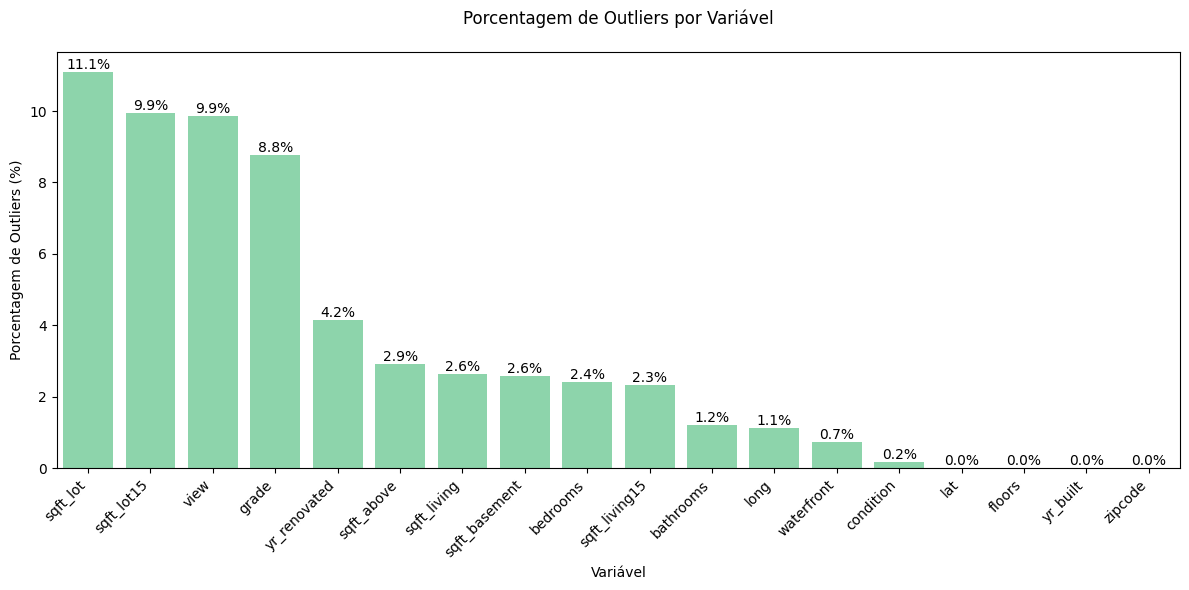

,caracteristica,total_registros,n_outliers,pct_outliers
3,sqft_lot,17290,1917,11.09
17,sqft_lot15,17290,1721,9.95
6,view,17290,1704,9.86
8,grade,17290,1518,8.78
12,yr_renovated,17290,719,4.16
9,sqft_above,17290,505,2.92
2,sqft_living,17290,459,2.65
10,sqft_basement,17290,448,2.59
0,bedrooms,17290,419,2.42
16,sqft_living15,17290,401,2.32


In [8]:
# Analisa outliers

df_outliers = check_outliers(X_train, colunas_numericas)

# Visualização dos resultados
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_outliers,
    x='caracteristica',
    y='pct_outliers',
    color='#2ecc71',
    alpha=0.6
)

plt.title('Porcentagem de Outliers por Variável', pad=20)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variável')
plt.ylabel('Porcentagem de Outliers (%)')

# Adiciona valores nas barras
for i, v in enumerate(df_outliers['pct_outliers']):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


df_outliers

In [9]:
def tratar_outliers(data, columns, factor=1.5):
    """
    Trata outliers usando o método IQR
    
    Args:
        df: DataFrame com os dados
        columns: Lista de colunas para tratar
        factor: Fator multiplicador do IQR (padrão = 1.5)
    
    Returns:
        DataFrame com outliers tratados
    """
    df_tratado = data.copy()
    
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Substituir outliers pelos limites
        df_tratado[col] = df_tratado[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_tratado

In [11]:
# Tratar outliers
X_train_tratado = tratar_outliers(X_train, colunas_numericas)


In [12]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_tratado), columns=X_train_tratado.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,-0.421691,-0.480397,-0.327410,0.890326,-0.9196,0.0,0.0,0.911498,1.404990,0.017438,...,0.404001,0.0,-0.674631,-1.396617,0.459989,1.200410,1.118391,-0.688840,-0.507833,1.312849
1,-1.592472,-1.493291,-1.262726,-0.989275,-0.9196,0.0,0.0,-0.629125,-1.599744,-1.276462,...,-1.430565,0.0,0.750604,-0.060175,-0.546357,-1.084619,-0.751267,1.451715,-1.150407,-0.655273


In [15]:
# Define uma seed aleatória para reprodutibilidade
seed = 42

# Dicionário com configurações dos modelos de machine learning
modelos = {
    # Random Forest: Modelo baseado em múltiplas árvores de decisão
    "RandomForest": {
        'modelo': RandomForestRegressor(
            random_state=seed,  # Garante reprodutibilidade
            n_jobs=-1,            # Usa todas as CPUs disponíveis
            verbose=0             # Modo silencioso
        ),
        'parametros': {
            'modelo__n_estimators': Integer(100, 300),  # Número de árvores
            'modelo__max_depth': Integer(10, 40)        # Profundidade máxima
        }
    },
    
    # XGBoost: Implementação otimizada de Gradient Boosting
    "XGBoost": {
        'modelo': XGBRegressor(
            eval_metric="rmse",     # Métrica para regressão (erro quadrático médio)
            random_state=seed,   # Garante reprodutibilidade
            n_jobs=-1,             # Paralelização
            verbose=0              # Modo silencioso
        ),
        'parametros': {
            'modelo__n_estimators': Integer(100, 300),  # Número de rodadas de boosting
            'modelo__max_depth': Integer(3, 40),        # Profundidade máxima
            'modelo__learning_rate': (0.01, 0.3),       # Taxa de aprendizado
            'modelo__subsample': (0.5, 1.0)            # Taxa de subamostragem
        }
    }
}


In [ ]:
# Lista para armazenar os resultados de cada modelo
results = []

# Itera sobre cada modelo definido no dicionário 'models'
for name, model_info in modelos.items():
    print(f'Training {name} ......')   
    # Define o pipeline de processamento e modelagem
    pipeline = Pipeline([
        ('modelo', model_info['modelo'])            # Modelo ML
    ])

    # Configura a busca Bayesiana de hiperparâmetros
    bayes_search = BayesSearchCV(
        pipeline,                                 # Pipeline a ser otimizado
        model_info['parametros'],                     # Espaço de parâmetros
        cv=3,                                     # Validação cruzada com 3 folds
        n_iter=32,                               # Número de iterações
        scoring='neg_mean_squared_error',         # Métrica para regressão
        n_jobs=-1,                               # Paralelização
        random_state=seed                         # Semente aleatória
    )
    
    # Treina o modelo com busca de hiperparâmetros
    bayes_search.fit(X_train, y_train)

    # Faz previsões e calcula métricas
    y_pred = bayes_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Salva o Modelo
    with open(f'output/{name}_model.pkl', 'wb') as file:
        pickle.dump(bayes_search, file)

    # Armazena os resultados do modelo
    model_params = bayes_search.best_estimator_.named_steps['modelo'].get_params()
    results.append({
        "Model": name, 
        "Depth": model_params.get('max_depth', 'N/A'),
        "N Estimators": model_params.get('n_estimators', 'N/A'),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

# Converte resultados para DataFrame
df_results = pd.DataFrame(results)

# Salva resultados em CSV
df_results.to_csv('output/model_results.csv', index=False, encoding='utf-8')

# Ordena modelos por R2 (melhor primeiro)
df_results.sort_values(by='R2', ascending=False)

In [13]:
def analyze_feature_importance(df_importancia_features, n_features_principais=10, limite=0.95):
    """
    Analisa e visualiza a importância das features de um modelo.
    
    Args:
        df_importancia_features (pd.DataFrame): DataFrame com colunas 'feature' e 'importance'
        n_features_principais (int): Número de features principais para mostrar no gráfico
        limite (float): Limite para análise cumulativa (0-1)
    
    Returns:
        dict: Dicionário com resultados da análise
    """
    # Ordena e calcula a importância percentual
    importancia_features = df_importancia_features.copy()
    importancia_features = importancia_features.sort_values('importance', ascending=False)
    importancia_features['porcentagem_importancia'] = importancia_features['importance'] * 100
    
    # Gráfico de barras das N features principais
    plt.figure(figsize=(15, 8))
    sns.barplot(data=importancia_features.head(n_features_principais), 
                y='feature', 
                x='porcentagem_importancia',
                palette='viridis')
    plt.title(f'Top {n_features_principais} Features Mais Importantes no Modelo')
    plt.xlabel('Importância (%)')
    plt.ylabel('Features')
    
    # Adiciona valores percentuais
    for i, v in enumerate(importancia_features['porcentagem_importancia'].head(n_features_principais)):
        plt.text(v + 0.1, i, f'{v:.1f}%')
    
    plt.tight_layout()
    plt.show()
    
    # Análise cumulativa
    importancia_features['importancia_cumulativa'] = importancia_features['importance'].cumsum()
    
    return importancia_features

In [ ]:
results = []
with open('output/RandomForest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Faz previsões e calcula métricas
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Get feature importances from the best estimator
model_params = loaded_model.best_estimator_.named_steps['modelo'].get_params()

results.append({
        "Model": "RandomForest", 
        "MSE": mse,
        "RMSE": rmse,
        "Depth": model_params.get('max_depth', 'N/A'),
        "N Estimators": model_params.get('n_estimators', 'N/A'),
        "MAE": mae,
        "R2": r2
    })

pd.DataFrame(results)

In [16]:
random = RandomForestRegressor(
    random_state=seed,  # Ensures reproducibility
    verbose=0,         # Silent mode
    n_jobs=-1,         # Parallelization
    n_estimators=284,  # Number of trees
    max_depth=40       # Maximum depth
)

random.fit(X_train_scaled, y_train)

# Salva modelo
with open(f'output/random_forest_modelo_log.pkl', 'wb') as file:
    pickle.dump(random, file)

In [17]:

results = []
with open('output/random_forest_modelo_log.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Faz previsões e calcula métricas
y_pred = loaded_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Get best parameters safely
best_params = loaded_model.feature_importances_


results.append({
        "Model": "RandomForest", 
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

pd.DataFrame(results)




,Model,MSE,RMSE,MAE,R2
0,RandomForest,0.034669,0.186196,0.130339,0.878368


# Avaliação do Modelo Random Forest

## Métricas de Performance
- **R² (Coeficiente de Determinação)**: 0.878 (87.8%)
  - Excelente resultado, indicando que o modelo explica 87.8% da variabilidade dos preços
  - Valores acima de 0.7 são considerados bons para previsão de preços imobiliários

- **RMSE (Root Mean Square Error)**: 0.186
  - Como os dados estão em log, isso representa um erro médio de aproximadamente 18.6%
  - Adequado para previsões de preços imobiliários, onde variações são esperadas

- **MAE (Mean Absolute Error)**: 0.130
  - Erro absoluto médio de 13% nas previsões
  - Menor que o RMSE, indicando que os erros são relativamente consistentes

- **MSE (Mean Squared Error)**: 0.035
  - Valor baixo, confirmando a boa performance do modelo
  - Penaliza erros maiores devido ao quadrado

## Conclusão
O modelo demonstra excelente performance para previsão de preços imobiliários:
- Alta capacidade explicativa (R² = 87.8%)
- Erros consistentes e aceitáveis para o mercado imobiliário
- Adequado para uso em produção com monitoramento contínuo

## Recomendações
1. Monitorar performance em dados novos
2. Considerar retreinamento periódico
3. Usar em conjunto com conhecimento de especialistas do mercado

In [18]:
# Unir X_test e y_test em um único DataFrame
df_test = pd.concat([X_test, np.exp(y_test)], axis=1)
df_test['price_predicted'] = np.exp(y_pred)
df_test['price_error'] = np.abs(df_test['price'] - df_test['price_predicted'])

df_test.head()



,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,year,month,day,price,price_predicted,price_error
735,4,2.25,2070,8893,2.0,0,0,4,8,2070,...,47.4388,-122.162,2390,7700,2014,10,6,365000.0,3.814542e+05,16454.224978
2830,5,3.00,2900,6730,1.0,0,0,5,8,1830,...,47.6784,-122.285,2370,6283,2014,8,21,865000.0,8.204655e+05,44534.476875
4106,4,2.50,3770,10893,2.0,0,2,3,11,3770,...,47.5646,-122.129,3710,9685,2014,8,15,1038000.0,1.089413e+06,51413.139893
16218,3,3.50,4560,14608,2.0,0,2,3,12,4560,...,47.6995,-122.228,4050,14226,2015,3,31,1490000.0,1.967115e+06,477115.036955
19964,3,2.50,2550,5376,2.0,0,0,3,9,2550,...,47.6647,-122.083,2250,4050,2014,7,14,711000.0,7.092674e+05,1732.594305



Análise dos Erros:
--------------------------------------------------
Erro Médio: $77,154.16
Erro Percentual Médio: 13.19%
Mediana do Erro Percentual: 9.01%


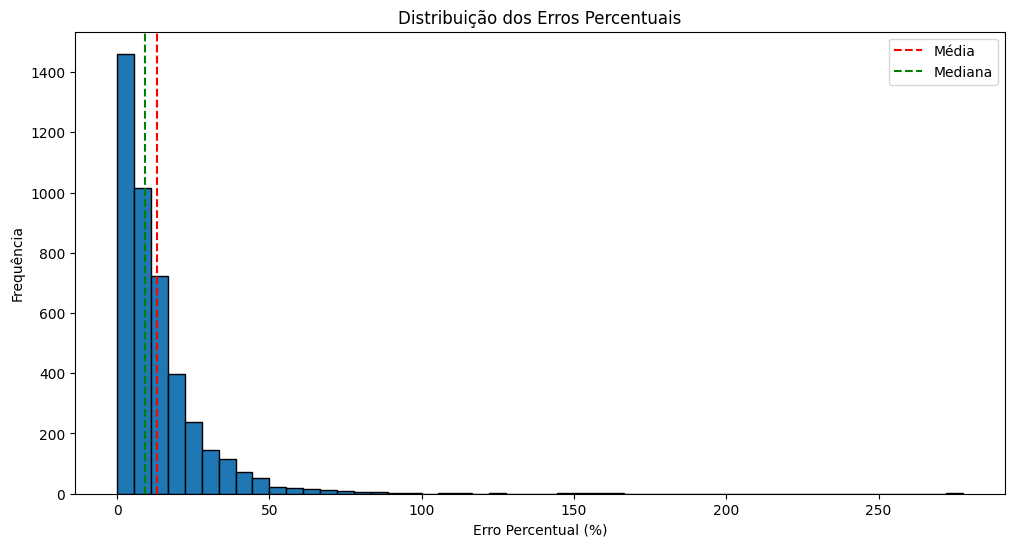

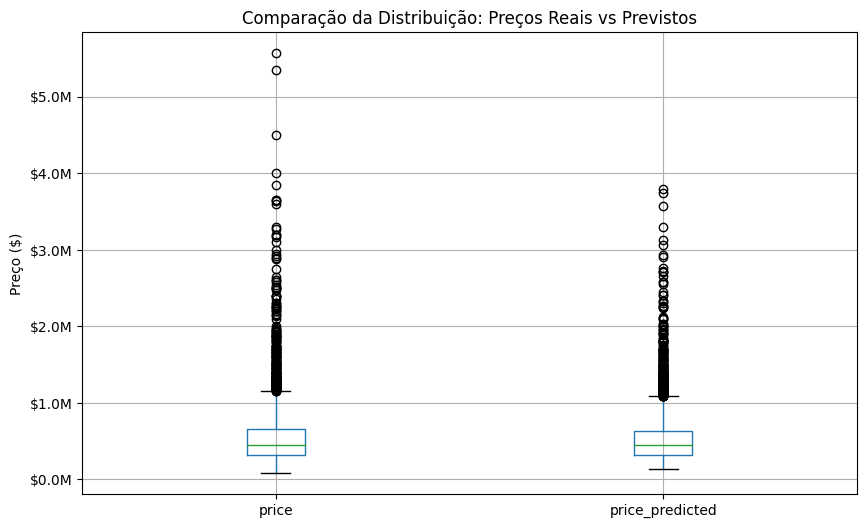

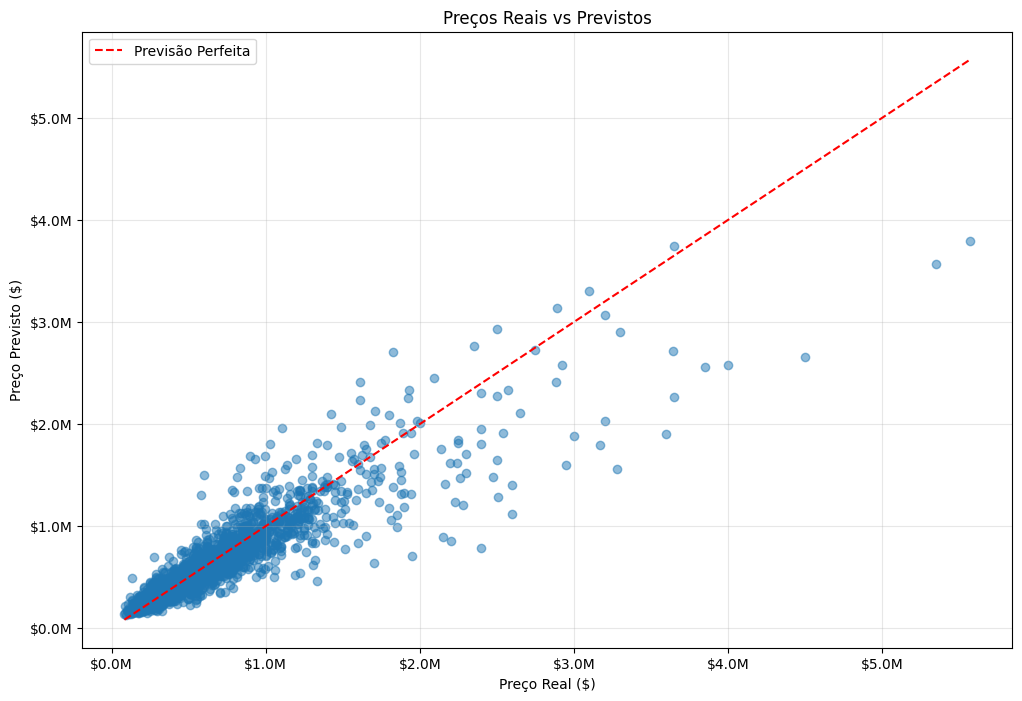


Erro por Faixa de Preço:
--------------------------------------------------
              mean  median    std
faixa_preco                      
Muito Baixo  17.70   10.67  21.70
Baixo        10.92    7.90  10.45
Médio        10.49    7.95   9.61
Alto         10.98    7.56  12.15
Muito Alto   15.76   12.09  14.39


In [19]:
# Calculando métricas de erro percentual
df_test['erro_percentual'] = (df_test['price_error'] / df_test['price']) * 100

print("\nAnálise dos Erros:")
print("-" * 50)
print(f"Erro Médio: ${df_test['price_error'].mean():,.2f}")
print(f"Erro Percentual Médio: {df_test['erro_percentual'].mean():.2f}%")
print(f"Mediana do Erro Percentual: {df_test['erro_percentual'].median():.2f}%")


# Visualizações

# 1. Distribuição dos Erros Percentuais
plt.figure(figsize=(12, 6))
plt.hist(df_test['erro_percentual'], bins=50, edgecolor='black')
plt.title('Distribuição dos Erros Percentuais')
plt.xlabel('Erro Percentual (%)')
plt.ylabel('Frequência')
plt.axvline(df_test['erro_percentual'].mean(), color='r', linestyle='--', label='Média')
plt.axvline(df_test['erro_percentual'].median(), color='g', linestyle='--', label='Mediana')
plt.legend()
plt.show()

# 2. Boxplot dos Preços
plt.figure(figsize=(10, 6))
df_test[['price', 'price_predicted']].boxplot()
plt.title('Comparação da Distribuição: Preços Reais vs Previstos')
plt.ylabel('Preço ($)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.show()

# 3. Scatter plot com linha de referência
plt.figure(figsize=(12, 8))
plt.scatter(df_test['price'], df_test['price_predicted'], alpha=0.5)
plt.plot([df_test['price'].min(), df_test['price'].max()], 
         [df_test['price'].min(), df_test['price'].max()], 
         'r--', label='Previsão Perfeita')
plt.xlabel('Preço Real ($)')
plt.ylabel('Preço Previsto ($)')
plt.title('Preços Reais vs Previstos')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Análise por faixas de preço
df_test['faixa_preco'] = pd.qcut(df_test['price'], q=5, labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])
erro_por_faixa = df_test.groupby('faixa_preco')['erro_percentual'].agg(['mean', 'median', 'std']).round(2)
print("\nErro por Faixa de Preço:")
print("-" * 50)
print(erro_por_faixa)

In [ ]:
with open('output/random_forest_modelo_log.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Directly access the feature importances from the loaded model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': loaded_model.feature_importances_
})

feature_importance = analyze_feature_importance(feature_importance, 10, 0.95)
feature_importance.head(10)

In [ ]:
melhores_features = feature_importance.feature.head(10).to_list()
X_train[melhores_features]